In [1]:
import numpy as np
import sisl

In [2]:
# Carbon-carbon bond length in Angstrom
a_cc = 1.42

# Lattice vectors for a 2D graphene unit cell
a1 = [3 / 2 * a_cc, np.sqrt(3) / 2 * a_cc, 0.0]
a2 = [3 / 2 * a_cc, -np.sqrt(3) / 2 * a_cc, 0.0]
a3 = [0.0, 0.0, 20.0]  # vacuum in z

lattice = sisl.Lattice([a1, a2, a3], nsc=[3, 3, 1])

# Atomic positions
pos = [
    [0.0, 0.0, 0.0],
    [1.42, 0, 0.0],
    [0.0, 0.0, 0.0],
]

atoms = [
    sisl.Atom(6),  # Carbon
    sisl.Atom(6),  # Carbon
    sisl.Atom(1),
]

# Build geometry
geom = sisl.Geometry(pos, atoms, lattice=lattice)
# geom.plot(axes="xy", backend="matplotlib")

In [3]:
hamiltonian = sisl.Hamiltonian(geom)

t = 1.0

for ia in geom:
    if ia != 2:
        idx_a = hamiltonian.close(ia, R=[0.1, 1.44])
        hamiltonian[ia, idx_a[0]] = 0.0
        hamiltonian[ia, idx_a[1]] = t

In [4]:
import pandas as pd
from quant_met.routines import self_consistency_loop

V_list = np.linspace(0.1, 4.0, num=5)
results_list = []

n_k = 10
k_grid_obj = sisl.MonkhorstPack(hamiltonian.geometry, [n_k, n_k, 1])  # 2D grid

for V in V_list:
    hamiltonian.H[0, 2] = V
    hamiltonian.H[2, 0] = V

    solved_gap = self_consistency_loop(
        hamiltonian=hamiltonian,
        kgrid=k_grid_obj,
        hubbard_int_orbital_basis=[1.0, 1.0, 1.0],
        beta=1000,
        epsilon=1e-3,
    )
    results_list.append(
        {
            "V": V,
            "orbital_0": np.abs(solved_gap[0]),
            "orbital_1": np.abs(solved_gap[1]),
            "orbital_2": np.abs(solved_gap[2]),
        }
    )

results = pd.DataFrame(results_list).sort_values("V")
print(results)

       V  orbital_0  orbital_1  orbital_2
0  0.100   0.001611   0.003374   0.498237
1  1.075   0.041991   0.204795   0.337197
2  2.050   0.024783   0.341609   0.183174
3  3.025   0.012751   0.404702   0.108049
4  4.000   0.007033   0.437077   0.069956


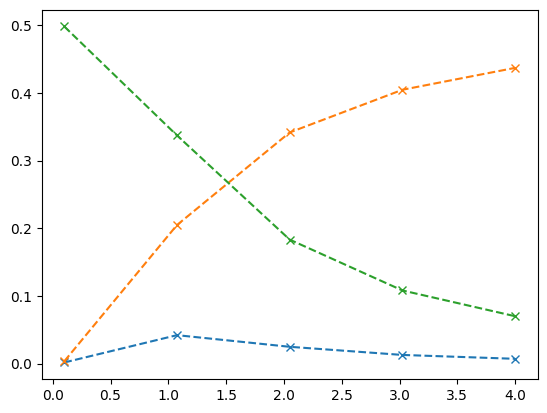

In [5]:
import matplotlib.pyplot as plt

plt.plot(results["V"], results["orbital_0"], "x--")
plt.plot(results["V"], results["orbital_1"], "x--")
plt.plot(results["V"], results["orbital_2"], "x--")